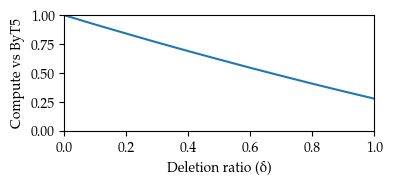

In [3]:
import matplotlib.pyplot as plt


plt.rcParams['font.family'] = 'P052'
plt.rcParams['font.serif'] = ['Times New Roman']

# Calculate the no. of flops used by a transformer model
def transformer_layer_macs(d_model: int, d_ff: int, seq_len: int) -> int:
    # Attention. Assumes d_head * n_head = d_model
    att_macs = (
        seq_len * d_model * d_model * 4 + # input and output projection
        seq_len * d_model * seq_len * 2   # QK^T and (QK^T)V
    )

    ffn_macs = (
        seq_len * d_ff * d_model * 2  # input and output projection
    )

    return att_macs + ffn_macs

def macs(d_model: int, n_encoder_layers: int, n_decoder_layers: int, d_ff: int, encoder_seq_length: int, decoder_seq_length: int, keep_ratio: float, deletion_layer: int) -> int:
    # deletion layer 0: delete after the embedding. 1: delete AFTER the first layer.
    encoder_deleted_seq_len = int(encoder_seq_length * keep_ratio)
    before_deletion = transformer_layer_macs(d_model, d_ff, encoder_seq_length) * deletion_layer
    after_deletion = transformer_layer_macs(d_model, d_ff, encoder_deleted_seq_len) * (n_encoder_layers - deletion_layer)

    decoder = transformer_layer_macs(d_model, d_ff, decoder_seq_length) * n_decoder_layers

    cross_attention = (
        encoder_deleted_seq_len * d_model * d_model * 2 + # K, V projections
        decoder_seq_length * d_model * d_model * 2 + # Q, output projection
        encoder_deleted_seq_len * decoder_seq_length * d_model * 2 # QK^T and (QK^T)V
    )

    return before_deletion + after_deletion + decoder + cross_attention * n_decoder_layers

krs = [a/10 for a in range(0, 11)]
m = []
for kr in krs:
    m.append(macs(d_model = 1472, d_ff = 3584, n_encoder_layers = 12, n_decoder_layers = 4, encoder_seq_length = 1024, decoder_seq_length = 189, deletion_layer = 3, keep_ratio = kr))

plt.figure(figsize=[4,1.5])
plt.plot([1-k for k in reversed(krs)], list(reversed([a/m[-1] for a in m])))
plt.xlabel('Deletion ratio (δ)')
plt.ylabel('Compute vs ByT5')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.savefig('figures/macs_relative.pdf', bbox_inches='tight')